In [31]:
import torchaudio 
import librosa
import matplotlib.pyplot as plt 
import numpy as np
import torch
import torchaudio.transforms as T

def plot_spectrogram(spec, title=None,
                     ylabel="freq_bin",
                     aspect="auto",
                     xmax=None, pow_to_db=True):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    if pow_to_db:
        im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    else:
        im = axs.imshow(spec, origin="lower", aspect=aspect)
    
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

### Enable to play audiio in VS code

In [32]:
import IPython.display
import numpy as np
import json

def Audio(audio: np.ndarray, sr: int):
    """
    Use instead of IPython.display.Audio as a workaround for VS Code.
    `audio` is an array with shape (channels, samples) or just (samples,) for mono.
    """

    if np.ndim(audio) == 1:
        channels = [audio.tolist()]
    else:
        channels = audio.tolist()

    return IPython.display.HTML("""
        <script>
            if (!window.audioContext) {
                window.audioContext = new AudioContext();
                window.playAudio = function(audioChannels, sr) {
                    const buffer = audioContext.createBuffer(audioChannels.length, audioChannels[0].length, sr);
                    for (let [channel, data] of audioChannels.entries()) {
                        buffer.copyToChannel(Float32Array.from(data), channel);
                    }
            
                    const source = audioContext.createBufferSource();
                    source.buffer = buffer;
                    source.connect(audioContext.destination);
                    source.start();
                }
            }
        </script>
        <button onclick="playAudio(%s, %s)">Play</button>
    """ % (json.dumps(channels), sr))

In [33]:
# audio_path = '/home/lev/datasets/musan/speech/librivox/speech-librivox-0000.wav'
# waveform, sample_rate = torchaudio.load(audio_path) # normalize to map waveform into [-1,1]
# waveform = waveform[:, :int(22050*1.3)]
# n_fft = 1024
# win_length = 1024
# hop_length = 220
# n_mels = 128

# n_stft = (n_fft//2)+1
# spectrogram = torchaudio.transforms.Spectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length)
# spec_to_melScale = torchaudio.transforms.MelScale(n_stft = n_stft)
# malScale_to_spec = torchaudio.transforms.InverseMelScale(n_stft=n_stft)
# spec_to_wav = torchaudio.transforms.InverseSpectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length)

# plt.imshow(spec_to_melScale(spectrogram(waveform))[0].detach().numpy())

### Audio Transform class

In [34]:
class AudioTransform():
    def __init__(self, **args):
        self.n_fft = args['n_fft']
        self.win_length = args['win_length']
        self.hop_length = args['hop_length']
        self.n_mels = args['n_mels']
        self.sample_rate = args['sample_rate']
        self.db = args['db']
        self.top_db = args['top_db']
        self.algo = args["algo"]
        self.device = args["device"]
        

        self.n_stft = self.n_fft//2 +1

        self.wav2mel = torchaudio.transforms.MelSpectrogram(
                        sample_rate=self.sample_rate,
                        n_fft=self.n_fft, n_mels=self.n_mels,
                        win_length=self.win_length, hop_length=self.hop_length,
                        
                        # to be consistent with librosa
                        center=True,
                        pad_mode="reflect",
                        power=2.0,
                        norm="slaney",
                        onesided=True,
                        mel_scale="htk",
                        ).to(self.device)

        self.wav2spec = torchaudio.transforms.Spectrogram( 
                            n_fft=self.n_fft,
                            win_length=self.win_length,
                            hop_length=self.hop_length,
                            center=True,
                            pad_mode="reflect",
                            onesided=True,
                            power=2
                            ).to(self.device)
            
        
        
        
        
        self.mel2spec = torchaudio.transforms.InverseMelScale(n_stft=self.n_stft, n_mels=self.n_mels, sample_rate=self.sample_rate).to(self.device)
        self.griffinLim = torchaudio.transforms.GriffinLim(n_fft=self.n_fft, win_length=self.win_length, hop_length=self.hop_length).to(self.device)
        self.spec2wav = torchaudio.transforms.InverseSpectrogram(n_fft=self.n_fft, win_length=self.win_length, hop_length=self.hop_length).to(self.device)
        self.power2DB = torchaudio.transforms.AmplitudeToDB(top_db=self.top_db).to(self.device)


        
                        
    def DB2power(self, x):
        return torchaudio.functional.DB_to_amplitude(x=x,ref=1.0, power=1)
    
    # WAV to Spectrograms
    def audio2spec(self, wav):
        return self.wav2spec(wav)

    def audio2mel(self, wav):
        M = self.wav2mel(wav)
        if self.db:
            M = self.power2DB(M)
        
        return M
    
    
    # Spectrograms to WAV
    def mel2wav(self, M):
        # db to power
        if self.db:
            M = self.DB2power(M)
        
        # mel spec to spec    
        spec = self.mel2spec(M)

        # spec to wav
        wav = self.spec2wav_f(spec)
        return wav

    def spec2wav_f(self, spec):
        # spec to wav
        if self.algo == 'griffinLim':
            wav = self.griffinLim(spec)
        else:
            wav = self.spec2wav(spec.to(dtype=torch.cdouble))
        return wav
        
        
        
device = torch.device('cuda')

            
at = AudioTransform(n_fft = 1024,
                win_length = None,
                hop_length = 512,
                n_mels = 128,
                sample_rate = 22050,
                db = True,
                top_db=120, algo='griffinLim', device=device
                )

audio_path = '/home/lev/datasets/musan/speech/librivox/speech-librivox-0001.wav'
waveform, sample_rate = torchaudio.load(audio_path) # normalize to map waveform into [-1,1]
waveform = waveform[:, :int(22050*1.3)].to(device)


M = at.audio2mel(waveform)
wav_mel = at.mel2wav(M)


spec = at.audio2spec(waveform)
wav_spec = at.spec2wav_f(spec)


### Normalization

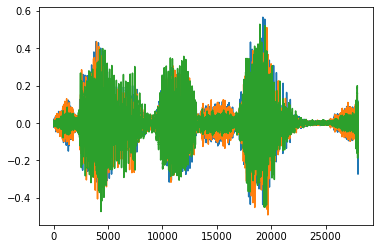

In [35]:
batch = torch.cat([waveform[:,:28000],
                wav_spec[:,:28000],
                wav_mel[:,:28000],
                ],dim=0)



batch_min =  batch.min(1, keepdim=True)[0]
batch_max = batch.max(1, keepdim=True)[0]
batch = (batch-batch_min)/(batch_max-batch_min)
batch -= batch.mean(1, keepdim=True)

plt.plot(batch[0].cpu(), label='original')
plt.plot(batch[1].cpu(), label='spec_rec')
plt.plot(batch[2].cpu(), label='mel_rec')

### Dataset

In [36]:
import glob
from torch.utils.data import DataLoader

import pytorch_lightning as pl
class MusanSynth(torch.utils.data.Dataset):
    # Simple class to load the desired folders inside ESC-50
    
    def __init__(self,  path, sample_rate: int = 22050, seed = 10):
        np.random.seed(seed)
        # Load CSV & initialize all torchaudio.transforms:
        # Resample --> MelSpectrogram --> AmplitudeToDB
        self.path = path
        
        paths = glob.glob(os.path.join(self.path,"*.npy"), recursive=True)

        self.labels_paths = np.array(sorted([ path for path in paths if "label" in path ]))
        self.mel_paths = np.array(sorted([ path for path in paths if "label" not in path ]))


    def __getitem__(self, index):
        # Returns (xb, yb) pair, after applying all transformations on the audio file.
        PATH = self.mel_paths[index]
        #LABEL_MEL = self.labels_paths[index]
        
        # load and normalize
        M = torch.Tensor(np.load(PATH)[np.newaxis,:]/80)
        #label = np.load(LABEL_MEL)
        assert list(M.shape) == [1,128,128]
        
        return M
        
    def __len__(self):
        # Returns length
        return len(self.mel_paths)


class MusanDataModule(pl.LightningDataModule):
    def __init__(
        self,
    ):
        super().__init__()
        
        self.train_batch_size = 64
        self.val_batch_size = 64
        self.num_workers = 4
        
        num_train_images = -1
        num_val_images = -1
        
        seed = 1


        train_path = "/home/lev/datasets/musan/synth_mel_train"
        val_path = "/home/lev/datasets/musan/synth_mel_val"
        # Load data
        self.train_dataset = MusanSynth(path = train_path)
        self.val_dataset = MusanSynth(path = val_path)
        

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.train_batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.val_batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )



In [83]:
import os
class AudioDataset(torch.utils.data.Dataset):
    # Simple class to load the desired folders inside ESC-50
    
    def __init__(self,  dataset_paths, dataset_names, sample_rate: int = 22050, normalize=False):
        """

        root_paths: paths to folders with .wav files. 
        Ex: [[<PATH TO DATASET/AUDIO TYPE FOLDER/*.WAV>], [<PATH TO DATASET/AUDIO TYPE FOLDER/*.WAV>]]
        
        sample_rate: default is 22050
        normalize: normalize audio uploaded audio into [-1 ,1] range
        """
        self.normalize = normalize
        self.sample_rate = sample_rate 
        self.unique_dataset_names = dataset_names

        self.audio_paths = list(map(lambda x: glob.glob(os.path.join(x,"**/*.wav"), recursive=True), dataset_paths))
        
        self.dataset_names = np.concatenate([len(paths)*[name] for name, paths  in zip(self.unique_dataset_names, self.audio_paths)])
        self.audio_paths = np.concatenate(self.audio_paths)

    


    def __getitem__(self, index):
        # Returns (xb, yb) pair, after applying all transformations on the audio file.
        print(self.audio_paths[index])
        PATH, NAME = self.audio_paths[index], self.dataset_names[index]
        waveform, sample_rate = torchaudio.load(PATH, normalize=self.normalize) # normalize to map waveform into [-1,1]

        # check input audio consistent with default sr 
        assert sample_rate == self.sample_rate
        return waveform, NAME
        
    def __len__(self):
        # Returns length
        return len(self.audio_paths)



dataset_paths = [  '/home/lev/datasets/musan/music',
                '/home/lev/datasets/musan/speech'
                ]
dataset_names = ['music', 'speech']

audio_dataset = AudioDataset(dataset_paths=dataset_paths,dataset_names=dataset_names)

In [54]:
root_path = '/home/lev/datasets/musan/synth_mel_train'
#musan = MusanSynth(path = root_path)
musan = MusanDataModule()
train_dataloader =musan.train_dataloader()
device = torch.device('cuda')
at = AudioTransform(n_fft = 1024,
                win_length = None,
                hop_length = 220,
                n_mels = 128,
                sample_rate = 22050,
                db = True,
                top_db=80, algo='griffinLim', device=device
                )

In [9]:
for batch in train_dataloader:

    break

wav_mel = at.mel2wav(batch.squeeze(1).to(torch.device('cuda')))

In [16]:
Audio(wav_mel[5], 22050)



tensor([-0.0185,  0.0024, -0.0139,  ..., -0.0255,  0.0076,  0.0216],
       device='cuda:0')

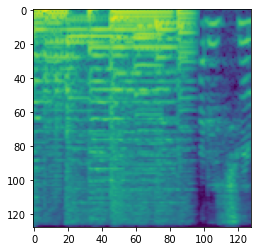

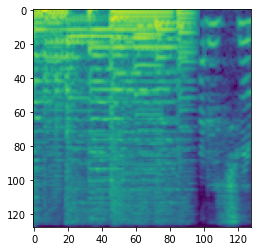

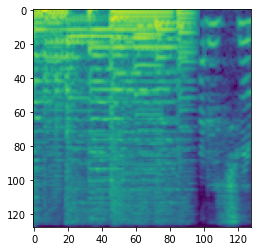

AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [26]:
plt.imshow(batch[1,0])
plt.show()
M = at.DB2power(batch[1,0])
plt.imshow(M)
plt.show()
#at.mel2spec()
M = librosa.db_to_power(batch[1,0].cpu().numpy())
plt.imshow(M)
plt.show()


      
# # mel spec to spec    
spec = at.mel2spec(M.to(device))

# # spec to wav
wav = at.spec2wav_f(spec)

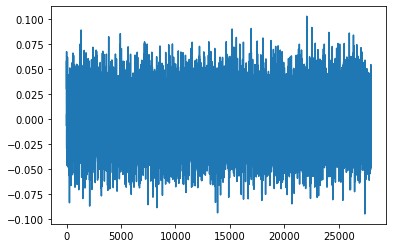

In [24]:
plt.plot(wav.cpu())

In [21]:
(batch[5,0] - M)**2

tensor([[0.6758, 0.7457, 1.0330,  ..., 0.6768, 0.7282, 0.6418],
        [0.6597, 0.7209, 1.0120,  ..., 0.7176, 0.7682, 0.6507],
        [0.6400, 0.7108, 0.9642,  ..., 0.8040, 0.7700, 0.6766],
        ...,
        [1.9394, 1.9394, 1.9394,  ..., 1.2127, 1.1824, 1.2227],
        [1.9394, 1.9394, 1.9394,  ..., 1.6029, 1.4744, 1.4401],
        [1.9394, 1.9394, 1.9394,  ..., 1.9394, 1.9394, 1.9394]])

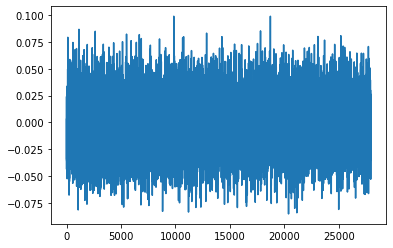

In [176]:
plt.plot(wav_mel[5,0].cpu())

In [113]:
Audio(batch[0], 22050)

In [114]:
Audio(batch[1], 22050)

In [115]:
Audio(batch[2], 22050)

In [124]:
grifin_lim = torchaudio.transforms.GriffinLim(n_fft=1024, hop_length=512).to(torch.device('cuda'))


tensor([[ 0.0172, -0.0046, -0.0181,  ...,  0.0795,  0.0720,  0.0637]],
       device='cuda:0')

In [82]:
grifin_lim

tensor([[0.9362],
        [0.4546],
        [0.9906]], dtype=torch.float64)

In [76]:
batch.mean(1, keepdim=True)

tensor([[97.5155],
        [97.5057],
        [97.5250]], dtype=torch.float64)

In [ ]:
A -= A.min(1, keepdim=True)[0]
A /= A.max(1, keepdim=True)[0]

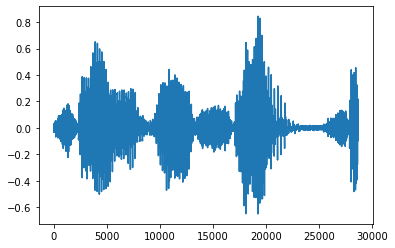

In [12]:

plt.plot(waveform[0])
#plt.plot(wav_mel[0])
#plt.plot(wav_spec[0])


In [ ]:
A -= A.min(1, keepdim=True)[0]
A /= A.max(1, keepdim=True)[0]

In [65]:
Audio(wav, sample_rate)

In [62]:
torch.square(waveform[0, :28000] - wav[0, :28000]).mean()

tensor(0.0330)

### Compare librosa vs torchaudio melspec

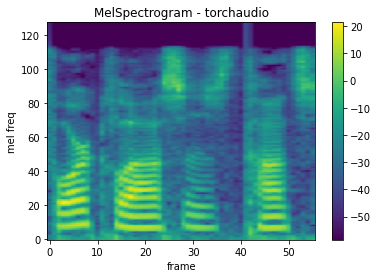

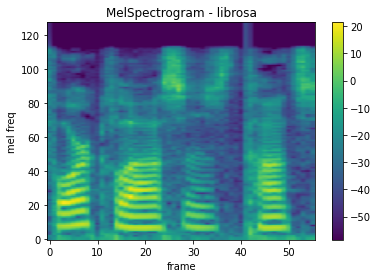

Mean Square Difference:  6.079505648903805e-11


In [14]:


audio_path = '/home/lev/datasets/musan/speech/librivox/speech-librivox-0000.wav'
waveform, sample_rate = torchaudio.load(audio_path) # normalize to map waveform into [-1,1]
waveform = waveform[:, :int(22050*1.3)]
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128
sample_rate = 22050

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(waveform)
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq", pow_to_db=True)

melspec_librosa = librosa.feature.melspectrogram(
    waveform.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm="slaney",
    htk=True,
)
plot_spectrogram(melspec_librosa, title="MelSpectrogram - librosa", ylabel="mel freq")

mse = torch.square(melspec - melspec_librosa).mean().item()
print("Mean Square Difference: ", mse)

Audio(waveform, sr=22050)

In [40]:
power_to_db = torchaudio.transforms.AmplitudeToDB(top_db=80)

lib_db_melspec = torch.Tensor(librosa.power_to_db(melspec))
torch_db_melspec = power_to_db(melspec)
mse = torch.square(lib_db_melspec - torch_db_melspec).mean().item()
print("Mean Square Difference for power scaled melspecs: ", mse)

melspec_back = torchaudio.functional.DB_to_amplitude(x= torch_db_melspec,ref=1.0, power=1)
mse = torch.square(melspec- melspec_back).mean().item()
print("Mean Square Difference for back scaled to power: ", mse)


Mean Square Difference for power scaled melspecs:  2.0998812768919378e-13
Mean Square Difference for back scaled to power:  1.1004397263217336e-12


### Back to audio without complex part

Audio rec mse 0.015707177485422903


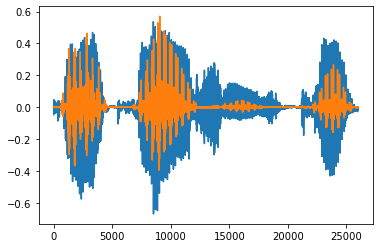

In [41]:
n_stft = n_fft//2 +1
inverse_mel_scale = torchaudio.transforms.InverseMelScale(n_stft=n_stft, n_mels=n_mels, sample_rate=22050)
inverse_spec = torchaudio.transforms.InverseSpectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length)
spec = inverse_mel_scale(melspec_back)
length = 28665
audio_rec = inverse_spec(spec.to(dtype=torch.cdouble), length)
print("Audio rec mse", torch.square(waveform -audio_rec).mean().item())

plt.plot(waveform[0,:26000].numpy())
plt.plot(audio_rec[0,:26000].numpy())
plt.show()

Audio(audio_rec, sample_rate)

### Back to audio with complex part

Audio rec mse 3.210817299970775e-15


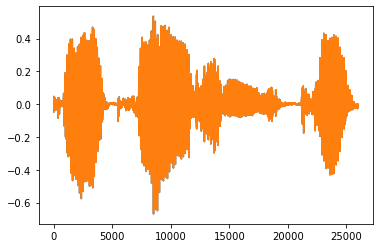

In [42]:
spectrogram = T.Spectrogram( 
    
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    onesided=True,
    return_complex=True,
    power=None
)

spec_complex = spectrogram(waveform)
inverse_spec = torchaudio.transforms.InverseSpectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length)
audio_rec = inverse_spec(spec_complex, length)
print("Audio rec mse", torch.square(waveform - audio_rec).mean().item())
plt.plot(waveform[0,:26000].numpy())

plt.plot(audio_rec[0,:26000].numpy())
plt.show()
Audio(audio_rec, sample_rate)

### GriffinLim

Audio rec mse 0.022343114018440247


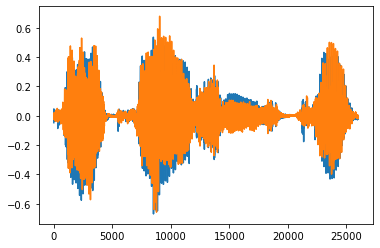

In [43]:
spectrogram = T.Spectrogram( 
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    onesided=True,
    power=2
)
griffinlim = torchaudio.transforms.GriffinLim(n_fft=n_fft, win_length=win_length, hop_length=hop_length, n_iter=32)

audio_rec  = griffinlim(spectrogram(waveform))

print("Audio rec mse", torch.square(waveform[0,:26000] - audio_rec[0,:26000]).mean().item())
plt.plot(waveform[0,:26000].numpy())

plt.plot(audio_rec[0,:26000].numpy())
plt.show()
Audio(audio_rec, sample_rate)

tensor([[ 0.0384,  0.0036,  0.0736,  ...,  0.0335,  0.1221, -0.1038]])

In [88]:
torchaudio.__version__

'0.10.1'

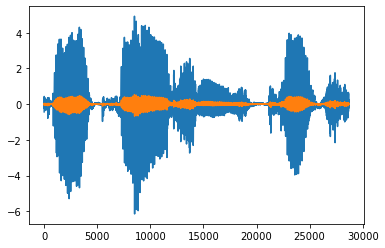

In [80]:
plt.plot(((audio_rec-audio_rec.mean())/audio_rec.std())[0])
plt.plot(waveform[0])


In [24]:

M = np.load("/home/lev/datasets/musan/synth_mel_train/mel-id-1.npy")

# plt.imshow(M)
# plt.show()
# plt.imshow(librosa.db_to_power(M))
# plt.show()
#M_spec = malScale_to_spec(torch.Tensor(librosa.db_to_power(M)))


In [64]:
M_spec = malScale_to_spec(torch.Tensor(librosa.db_to_power(M)))
M_spec = M_spec.unsqueeze(0).to(dtype=torch.cdouble)

wav = spec_to_wav(M_spec, length=int(22050*1.3))

In [65]:
Audio(wav.detach().numpy(), sr=22050)

In [42]:
batch, freq, time = 2, 257, 100
length = 25344
spectrogram = torch.randn(batch, freq, time, dtype=torch.cdouble)
transform = torchaudio.transforms.InverseSpectrogram(n_fft=512)
waveform = transform(spectrogram, length)

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def get_log_melspectrogram(audio, sr = 22050, hop_length = 220, n_fft = 1024, n_mels = 128, visualize=True):
    """Return the log-scaled Mel bands of an audio signal."""
    audio_norm =(audio-audio.mean()) / audio.std()
    bands = librosa.feature.melspectrogram(
        y=audio_norm, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=n_mels, dtype=np.float32)
    M =librosa.core.power_to_db(bands, amin=1e-7)
    if visualize:
        plt.imshow(M)
    return M

In [33]:
waveform.shape[]

torch.Size([1, 6937293])

In [ ]:
import IPython.display
import numpy as np
import json

def Audio(audio: np.ndarray, sr: int):
    """
    Use instead of IPython.display.Audio as a workaround for VS Code.
    `audio` is an array with shape (channels, samples) or just (samples,) for mono.
    """

    if np.ndim(audio) == 1:
        channels = [audio.tolist()]
    else:
        channels = audio.tolist()

    return IPython.display.HTML("""
        <script>
            if (!window.audioContext) {
                window.audioContext = new AudioContext();
                window.playAudio = function(audioChannels, sr) {
                    const buffer = audioContext.createBuffer(audioChannels.length, audioChannels[0].length, sr);
                    for (let [channel, data] of audioChannels.entries()) {
                        buffer.copyToChannel(Float32Array.from(data), channel);
                    }
            
                    const source = audioContext.createBufferSource();
                    source.buffer = buffer;
                    source.connect(audioContext.destination);
                    source.start();
                }
            }
        </script>
        <button onclick="playAudio(%s, %s)">Play</button>
    """ % (json.dumps(channels), sr))